In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
train = pd.read_csv('./data/train.csv', sep=';')
data = pd.read_csv('./data/data.csv', sep=';')
test = pd.read_csv('./data/test.csv')

In [3]:
train_target = data.merge(train, on='ID')

In [4]:
s= 'Вопрос  такой   Что если заметил неправильный ответ у видущего???)))\
Вопрос про актера неснимавщеося комиком стендапером.  Ответ был типо Эдди Мерфи.\
Но он был в этой роли в фильме чокнутый профессор'
s1 = 'Каково расстояние от Земли до Луны?'
s2= 'В каком году родился А.С. Пушкин ?'
s3 = 'Кто написал сказку «Конек-горбунок»?'
s4 = 'Самая быстрая сборка кубика Рубика в мире?\n(Секунды)'
s5 = 'Какой клуб стал победителем Лиги чемпионов УЕФА 1999\/2000?'
s6 = 'Самая быстрая рыба в мире? Развивающая скорость под водой 100 км/ч'

re.findall(r"\\/", s5)

['\\/']

In [5]:
question_words = ['как', 'какая', 'какой', 'когда', 'где', 'сколько',
                 'какое', 'кто', 'что', 'кому', 'кем', 'какова',
                  'самое', 'чем', 'кого', 'чего', 'чьим']

question_words_2 = ['каком', 'какого', 'какой', 'каком', 'каким',
                    'какими', 'какому', 'сколько', 'чём', 'чему',
                    'скольких', 'чего', 'время']

propositions = ['в', 'с', 'от', 'у', 'за', 'из', 'на', 'к', 'про', 'через']

punct = ['\"', '@', '#', '№', '$', ';', '%', '^', ':', '&',
         '*', '+', '=', '<', '>', '{', '}', '|', ']', '[']

punct_common = ['(', ')', '/']

In [6]:
def get_features(df):
    df['word_cnt'] = df.Question.map(lambda x: len(x.split(' ')))
    df['char_cnt'] = df.Question.map(lambda x: len(x))
    df['alpha_cnt'] = df.Question.map(lambda s: sum([x.isalpha() for x in s]))
    df['decimal_cnt'] = df.Question.map(lambda s: sum([x.isdecimal() for x in s]))
    df['lower_cnt'] = df.Question.map(lambda s: sum([x.islower() for x in s]))
    df['space_cnt'] = df.Question.map(lambda s: sum([x.isspace() for x in s]))
    df['upper_cnt'] = df.Question.map(lambda s: sum([x.isupper() for x in s]))
    df['first_letter_is_upper'] = df.Question.map(lambda s: int(s[0].isupper()))

    df['starts_with_question_words'] = df.Question.map(lambda s: int(s.lower().split(' ')[0] in question_words))
    
    df['second_word_in_qustion_words_2'] = df.Question.map(lambda s: int(s.lower().split(' ')[1] in question_words_2) \
                                                           if (len(s.split(' ')) > 1) \
                                                          else 0)
    
    df['starts_with_proposition'] = df.Question.map(lambda s: int(s.lower().split(' ')[0] in propositions))
    
    df['ends_with_question'] = df.Question.map(lambda s: int(s.endswith('?')))
    df['has_chars_repeats'] = df.Question.map(lambda s: len(re.findall(r"(.)\1{2,}", s)))
    df['has_space_before_question'] = df.Question.map(lambda s: len(re.findall(r" \?", s)))
    df['has_many_spaces'] = df.Question.map(lambda s: len(re.findall(r" {2,}", s)))
    
    df['has_punct_char'] = df.Question.map(lambda s: sum(x in punct for x in s))
    df['has_punct_char_common'] = df.Question.map(lambda s: sum(x in punct_common for x in s))
    df['has_special_choice_sign'] = df.Question.map(lambda s: len(re.findall(r"\\/", s)))
    return df

In [7]:
train_features = get_features(train_target)

In [12]:
train_features.columns

Index(['ID', 'Question', 'Answer', 'word_cnt', 'char_cnt', 'alpha_cnt',
       'decimal_cnt', 'lower_cnt', 'space_cnt', 'upper_cnt',
       'first_letter_is_upper', 'starts_with_question_words',
       'second_word_in_qustion_words_2', 'starts_with_proposition',
       'ends_with_question', 'has_chars_repeats', 'has_space_before_question',
       'has_many_spaces', 'has_punct_char', 'has_punct_char_common',
       'has_special_choice_sign'],
      dtype='object')

In [13]:
features = ['word_cnt', 'char_cnt', 'alpha_cnt',
       'decimal_cnt', 'lower_cnt', 'space_cnt', 'upper_cnt',
       'first_letter_is_upper', 'starts_with_question_words',
       'second_word_in_qustion_words_2', 'starts_with_proposition',
       'ends_with_question', 'has_chars_repeats', 'has_space_before_question',
       'has_many_spaces', 'has_punct_char', 'has_punct_char_common',
       'has_special_choice_sign']

features_text = ['Question']

target = 'Answer'

In [14]:
def plot(feature):
    
    sns.catplot('Answer', feature,  data=train_target, kind='violin', height=8.27, aspect=11.7/8.27)
    plt.grid()

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer
import numpy as np
from time import time

### Text features

In [40]:
X, y = train_features[features_text].values.tolist(), train_features[target]

In [60]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
tokenizer = lambda x: x[0]

vectorizers = [
               CountVectorizer(preprocessor=tokenizer, ngram_range=(1, 1), analyzer='char_wb'),
              CountVectorizer(preprocessor=tokenizer, ngram_range=(1, 2), analyzer='char_wb'),
              CountVectorizer(preprocessor=tokenizer, ngram_range=(1, 3), analyzer='char_wb'),
              CountVectorizer(preprocessor=tokenizer, ngram_range=(1, 4), analyzer='char_wb'),
              CountVectorizer(preprocessor=tokenizer, ngram_range=(1, 5), analyzer='char_wb'),
               CountVectorizer(preprocessor=tokenizer, ngram_range=(1, 6), analyzer='char_wb')
              ]

for vect in vectorizers:
    classifier = Pipeline([('vect', vect), ('model', LogisticRegression(C=0.01))])
    ts = time()
    tmp = cross_val_score(classifier, X, y,
                              scoring='roc_auc',
                              cv=cv, n_jobs=-1, verbose=50)
    
    print('Vectorizer: {} \n Mean val roc-auc score: {} +/- {} \n Time: {}' \
          .format(vect, np.mean(tmp), np.std(tmp), time() - ts))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished
Vectorizer: CountVectorizer(analyzer='char_wb', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1),
                preprocessor=<function <lambda> at 0x7f93fb2b92f0>,
                stop_words=None, strip_accents=None,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None,
                vocabulary=None) 
 Mean val roc-auc score: 0.7336133895923606 +/- 0.005832985729070453 
 Time: 1.741222858428955
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      

In [ ]:
'''

Vectorizer: CountVectorizer(analyzer='char_wb', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 4),
                preprocessor=<function <lambda> at 0x7f93fb2b92f0>,
                stop_words=None, strip_accents=None,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None,
                vocabulary=None) 
 Mean val roc-auc score: 0.7805309703136819 +/- 0.0024172929033335518 
 
 '''

In [62]:
classifier.fit(X, y)
y_hat_bow = classifier.predict_proba(X)[:, 1]
roc_auc_score(y, y_hat_bow)

/home/fed/Projects/Competitions/vkcup/venv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9057084373237447

## Chars features

In [63]:
import lightgbm

X, y = train_features[features].values, train_features[target].values

In [64]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ts = time()
model = lightgbm.LGBMClassifier(
                                num_leaves=31,
                                max_depth=-1,
                                learning_rate=0.05,
                               #n_estimators=1000
                               )

tmp = cross_val_score(model, X, y,
                              scoring='roc_auc',
                              cv=cv, n_jobs=-1, verbose=50)
    
print('Mean val roc-auc score: {} +/- {} \n Time: {}' \
          .format(np.mean(tmp), np.std(tmp), time() - ts))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
Mean val roc-auc score: 0.7576471278824366 +/- 0.009042927689273459 
 Time: 0.5284392833709717


In [65]:
model.fit(X, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [66]:
y_hat = model.predict_proba(X)[:, 1]

In [67]:
roc_auc_score(y, y_hat)

0.8020518942792111

In [68]:
feature_importances = {k: v for k, v in  zip(features, model.feature_importances_)}

In [69]:
feature_importances

{'word_cnt': 389,
 'char_cnt': 544,
 'alpha_cnt': 520,
 'decimal_cnt': 98,
 'lower_cnt': 321,
 'space_cnt': 35,
 'upper_cnt': 311,
 'first_letter_is_upper': 74,
 'starts_with_question_words': 136,
 'second_word_in_qustion_words_2': 60,
 'starts_with_proposition': 53,
 'ends_with_question': 100,
 'has_chars_repeats': 40,
 'has_space_before_question': 79,
 'has_many_spaces': 72,
 'has_punct_char': 101,
 'has_punct_char_common': 67,
 'has_special_choice_sign': 0}

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators=1000,
                           max_depth=7)

tmp = cross_val_score(rf, X, y,
                              scoring='roc_auc',
                              cv=5,
                      n_jobs=-1,
                      verbose=50)
    
print('Mean val roc-auc score: {} +/- {} \n Time: {}' \
          .format(np.mean(tmp), np.std(tmp), time() - ts))

In [ ]:
rf.fit(X, y)
y_hat_rf = rf.predict_proba(X)[:, 1]

In [ ]:
roc_auc_score(y, y_hat_rf)

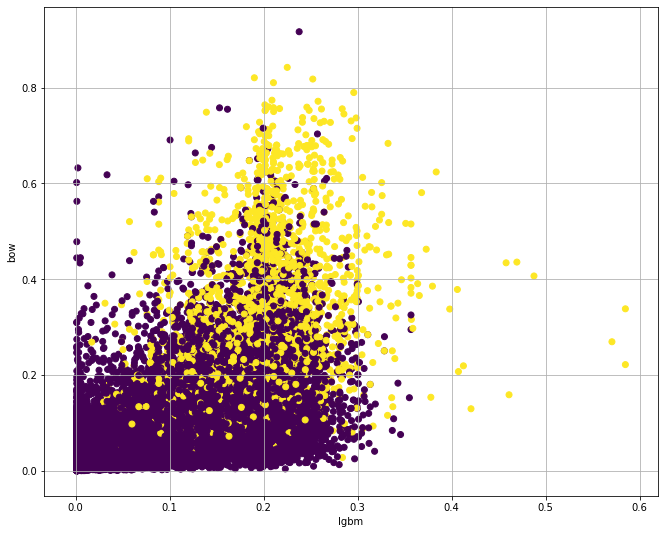

In [70]:
plt.figure(figsize=(11, 9))
plt.scatter(y_hat, y_hat_bow, c=y)
plt.xlabel('lgbm')
plt.ylabel('bow')
plt.grid()
plt.show()

# Submit

In [71]:
test_questions = test.merge(data, on="ID")

In [72]:
test_features = get_features(test_questions)
test_text_features = test_questions[features_text].values.tolist()

In [73]:
y_hat = model.predict_proba(test_features[features])[:, 1]
y_hat_bow = classifier.predict_proba(test_text_features)[:, 1]

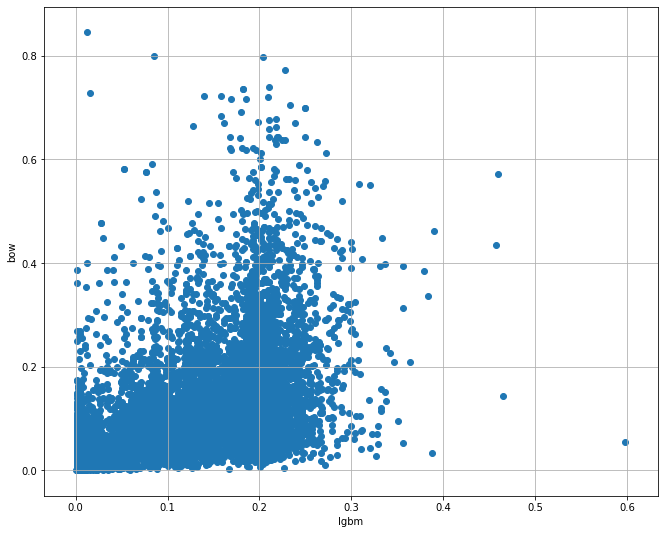

In [74]:
plt.figure(figsize=(11, 9))
plt.scatter(y_hat, y_hat_bow)
plt.xlabel('lgbm')
plt.ylabel('bow')
plt.grid()
plt.show()

In [76]:
test['pred'] = y_hat_bow

In [77]:
test.to_csv('./submits/bow.csv', index=False, header=False)